# The Glucose Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

In [4]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/data/glucose_insulin.csv')

In [5]:
data = pd.read_csv('glucose_insulin.csv', index_col='time');

In [6]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05

In [7]:
params = G0, k1, k2, k3

`make_system` takes the parameters and actual data and returns a `System` object.

In [8]:
from chap18 import make_system
from chap18 import slope_func

In [9]:
system = make_system(params, data)

Here's how we run the ODE solver.

In [10]:
results, details = run_solve_ivp(system, slope_func, 
                                  t_eval=data.index)

In [11]:
details.message

'The solver successfully reached the end of the integration interval.'

In [12]:
results.head()

,G,X
0,270.000000,0.000000
2,262.980942,0.000240
4,255.683455,0.002525
6,247.315442,0.005174
8,238.271851,0.006602


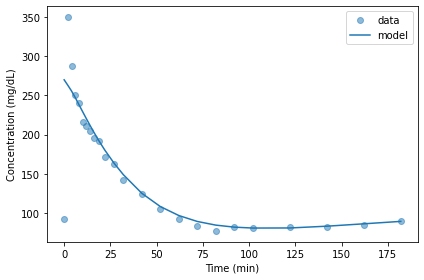

In [13]:
data.glucose.plot(style='o', alpha=0.5, label='data')
results.G.plot(style='-', color='C0', label='model')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [14]:
errors = results.G - data.glucose
errors.head()

0    178.000000
2    -87.019058
4    -31.316545
6     -3.684558
8     -1.728149
dtype: float64

In [15]:
errors.iloc[3:].abs().describe()

count    21.000000
mean      4.060127
std       3.742106
min       0.046105
25%       1.002881
50%       3.302437
75%       6.984791
max      13.294083
dtype: float64

## Optimization

Now let's find the parameters that yield the best fit for the data.  

We'll use these values as an initial estimate and iteratively improve them.

`error_func` takes the parameters and actual data, makes a `System` object, and runs `odeint`, then compares the results to the data.  It returns an array of errors.

In [16]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_solve_ivp(system, slope_func, 
                                     t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors.iloc[3:]

When we call `error_func`, we provide a sequence of parameters as a single object.

Here's how that works:

In [17]:
error_func(params, data)

(270, 0.02, 0.02, 1.5e-05)


6      -3.684558
8      -1.728149
10     13.294083
12      9.425807
14      6.752546
16      7.353682
19     -0.610979
22      8.260041
27      0.569221
32      6.984791
42      1.228652
52      3.302437
62      4.855592
72      5.283959
82      7.627294
92      0.046105
102    -0.105472
122    -1.002881
142     1.257581
162     1.293945
182    -0.594890
dtype: float64

`leastsq` is a wrapper for `scipy.optimize.leastsq`

Here's how we call it.

In [18]:
best_params, fit_details = leastsq(error_func, params, data)

[2.7e+02 2.0e-02 2.0e-02 1.5e-05]
[2.7e+02 2.0e-02 2.0e-02 1.5e-05]
[2.7e+02 2.0e-02 2.0e-02 1.5e-05]
[2.70000004e+02 2.00000000e-02 2.00000000e-02 1.50000000e-05]
[2.70000000e+02 2.00000003e-02 2.00000000e-02 1.50000000e-05]
[2.70000000e+02 2.00000000e-02 2.00000003e-02 1.50000000e-05]
[2.70000000e+02 2.00000000e-02 2.00000000e-02 1.50000002e-05]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05]
[2.71539227e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05]
[2.71539223e+02 2.40776796e-02 1.85336372e-02 1.31312411e-05]
[2.71539223e+02 2.40776792e-02 1.85336375e-02 1.31312411e-05]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312413e-05]
[2.70733829e+02 2.35942255e-02 1.56223467e-02 1.29654857e-05]
[2.70733833e+02 2.35942255e-02 1.56223467e-02 1.29654857e-05]
[2.70733829e+02 2.35942259e-02 1.56223467e-02 1.29654857e-05]
[2.70733829e+02 2.35942255e-02 1.56223469e-02 1.29654857e-05]
[2.70733829e+02 2.35942255e-02 1.56223467e-02 1.29654859e-05]
[2.73718410e+02 2.53505172e-02

The first return value is an array with the best parameters:

In [19]:
best_params

array([2.71593854e+02, 2.40849546e-02, 1.63029441e-02, 1.27991788e-05])

The second return value is a `ModSimSeries` object with information about the results.

In [20]:
fit_details.success

True

In [21]:
fit_details.mesg

'The relative error between two consecutive iterates is at most 0.000000'

Now that we have `best_params`, we can use it to make a `System` object and run it.

In [22]:
system2 = make_system(best_params, data)
results2, details = run_solve_ivp(system2, slope_func, 
                                 t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Here are the results, along with the data.  The first few points of the model don't fit the data, but we don't expect them to.

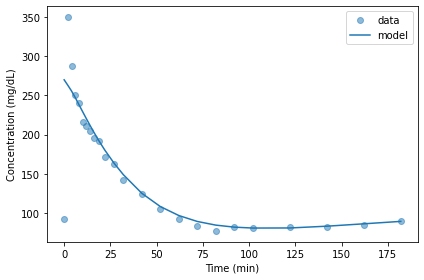

In [23]:
data.glucose.plot(style='o', alpha=0.5, label='data')
results.G.plot(style='-', color='C0', label='model')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [24]:
errors2 = results2.G - data.glucose
errors2.head()

0    179.593854
2    -86.885731
4    -32.457099
6     -5.859291
8     -4.873474
dtype: float64

In [25]:
errors2.iloc[3:].abs().describe()

count    21.000000
mean      3.143214
std       2.352147
min       0.423087
25%       1.543342
50%       2.129677
75%       4.981683
max       9.410441
dtype: float64

In [26]:
errors.abs().mean(), errors2.abs().mean()

(15.8999277933369, 15.206007804680405)

## Interpreting parameters

On the other hand, the other parameters are meaningful; in fact, they
are the reason the model is useful. Using the best-fit parameters, we
can estimate two quantities of interest:

-   "Glucose effectiveness", $E$, which is the tendency of elevated
    glucose to cause depletion of glucose.

-   "Insulin sensitivity", $S$, which is the ability of elevated blood
    insulin to enhance glucose effectiveness.

Glucose effectiveness is defined as the change in $dG/dt$ as we vary
$G$: 

$$E \equiv - \frac{\delta \dot{G}}{\delta G}$$ 

where $\dot{G}$ is shorthand for $dG/dt$. Taking the derivative of $dG/dt$ with respect to $G$, we get 

$$E = k_1 + X$$ 

The **glucose effectiveness index**, $S_G$, is the value of $E$ when blood insulin is near its basal level, $I_b$.
In that case, $X$ approaches 0 and $E$ approaches $k_1$. So we can use
the best-fit value of $k_1$ as an estimate of $S_G$.

Insulin sensitivity is defined as the change in $E$ as we vary $I$:

$$S \equiv - \frac{\delta E}{\delta I}$$ 

The **insulin sensitivity index**, $S_I$, is the value of $S$ when $E$ and $I$ are at steady state: $$S_I \equiv \frac{\delta E_{SS}}{\delta I_{SS}}$$ $E$ and $I$ are at steady state when $dG/dt$ and $dX/dt$ are 0, but we don't actually have to solve those equations to find $S_I$. 

If we set $dX/dt = 0$ and solve for $X$, we find the relation:

$$X_{SS} = \frac{k_3}{k_2} I_{SS}$$ 

And since $E = k_1 + X$, we have:

$$S_I = \frac{\delta E_{SS}}{\delta I_{SS}} = \frac{\delta X_{SS}}{\delta I_{SS}}$$

Taking the derivative of $X_{SS}$ with respect to $I_{SS}$, we have:

$$S_I = k_3 / k_2$$ 

So if we find parameters that make the model fit the data, we can use $k_3 / k_2$ as an estimate of $S_I$.

For the parameters we found that best fit the data, here are the estimated values of $S_G$ and $S_I$ 

In [27]:
G0, k1, k2, k3 = best_params
indices = SimpleNamespace(S_G=k1, S_I=k3/k2)
show(indices)

,value
S_G,0.024085
S_I,0.000785


According to [Boston et al](https://www.researchgate.net/publication/8931437_MINMOD_Millennium_A_Computer_Program_to_Calculate_Glucose_Effectiveness_and_Insulin_Sensitivity_From_the_Frequently_Sampled_Intravenous_Glucose_Tolerance_Test), normal ranges for these values are...

In [31]:
S_G_interval = 1.2e-3, 4.5e-2
S_G_interval

(0.0012, 0.045)

In [32]:
S_I_interval = 5.0e-5, 2.2e-3
S_I_interval

(5e-05, 0.0022)

The estimated values are within the normal intervals.

## Exercises

**Exercise:** Since we don't expect the first few points to agree, it's probably better not to make them part of the optimization process.  We can ignore them by leaving them out of the `Series` returned by `error_func`.  Modify the last line of `error_func` to return `errors.iloc[4:]`, which includes only the elements of the `Series` with index 4 and up.

Does that improve the quality of the fit?  Does it change the best parameters by much?  Does it change the computed sensitivities by much?

Note: You can read more about this use of `iloc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

**Exercise:** How sensitive are the results to the starting guess for the parameters?  If you try different values for the starting guess, do we get the same values for the best parameters?